In [1]:
import xarray
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

In [2]:
!ls ../data/stacks/ | wc -l

19


In [3]:
wd = Path("../data")
geojson = list(wd.glob("geojson/*.geojson"))[:19]

In [4]:
geojson

[PosixPath('../data/geojson/3476-7216-14.geojson'),
 PosixPath('../data/geojson/3927-7406-14.geojson'),
 PosixPath('../data/geojson/3671-7309-14.geojson'),
 PosixPath('../data/geojson/3486-7276-14.geojson'),
 PosixPath('../data/geojson/3478-7215-14.geojson'),
 PosixPath('../data/geojson/3575-7192-14.geojson'),
 PosixPath('../data/geojson/3485-7277-14.geojson'),
 PosixPath('../data/geojson/3704-7298-14.geojson'),
 PosixPath('../data/geojson/3485-7268-14.geojson'),
 PosixPath('../data/geojson/3919-7406-14.geojson'),
 PosixPath('../data/geojson/3482-7271-14.geojson'),
 PosixPath('../data/geojson/3489-7248-14.geojson'),
 PosixPath('../data/geojson/3623-7280-14.geojson'),
 PosixPath('../data/geojson/3476-7215-14.geojson'),
 PosixPath('../data/geojson/4109-7299-14.geojson'),
 PosixPath('../data/geojson/3562-7289-14.geojson'),
 PosixPath('../data/geojson/3438-7280-14.geojson'),
 PosixPath('../data/geojson/4165-7321-14.geojson'),
 PosixPath('../data/geojson/3571-7283-14.geojson')]

In [5]:
filepath = wd / "stacks" / f"{geojson[8].stem}.zarr"

In [6]:
data = xarray.open_zarr(filepath)

In [7]:
data

<xarray.Dataset>
Dimensions:                       (band: 11, time: 44, y: 231, x: 233)
Coordinates: (12/28)
  * band                          (band) <U8 'B02' 'B03' 'B04' ... 'B12' 'SCL'
    center_wavelength             (band) float64 dask.array<chunksize=(11,), meta=np.ndarray>
    common_name                   (band) object dask.array<chunksize=(11,), meta=np.ndarray>
    constellation                 <U10 ...
    created                       (time) <U24 dask.array<chunksize=(44,), meta=np.ndarray>
    eo:cloud_cover                (time) float64 dask.array<chunksize=(44,), meta=np.ndarray>
    ...                            ...
  * time                          (time) datetime64[ns] 2021-12-03T17:38:15 ....
    title                         (band) <U31 dask.array<chunksize=(11,), meta=np.ndarray>
    updated                       (time) <U24 dask.array<chunksize=(44,), meta=np.ndarray>
    view:off_nadir                int64 ...
  * x                             (x) float64 2.351e+06 2.351e+06 ... 2.354e+06
  * y                             (y) float64 8.774e+05 8.773e+05 ... 8.75e+05
Data variables:
    imagery                       (time, band, y, x) uint16 dask.array<chunksize=(11, 3, 116, 117), meta=np.ndarray>
    training                      (y, x) uint8 dask.array<chunksize=(231, 233), meta=np.ndarray>

In [8]:
data.imagery

<xarray.DataArray 'imagery' (time: 44, band: 11, y: 231, x: 233)>
dask.array<open_dataset-2995e4e60be440eb15260b2f680b074cimagery, shape=(44, 11, 231, 233), dtype=uint16, chunksize=(11, 3, 116, 117), chunktype=numpy.ndarray>
Coordinates: (12/28)
  * band                          (band) <U8 'B02' 'B03' 'B04' ... 'B12' 'SCL'
    center_wavelength             (band) float64 dask.array<chunksize=(11,), meta=np.ndarray>
    common_name                   (band) object dask.array<chunksize=(11,), meta=np.ndarray>
    constellation                 <U10 ...
    created                       (time) <U24 dask.array<chunksize=(44,), meta=np.ndarray>
    eo:cloud_cover                (time) float64 dask.array<chunksize=(44,), meta=np.ndarray>
    ...                            ...
  * time                          (time) datetime64[ns] 2021-12-03T17:38:15 ....
    title                         (band) <U31 dask.array<chunksize=(11,), meta=np.ndarray>
    updated                       (time) <U24 dask.array<chunksize=(44,), meta=np.ndarray>
    view:off_nadir                int64 ...
  * x                             (x) float64 2.351e+06 2.351e+06 ... 2.354e+06
  * y                             (y) float64 8.774e+05 8.773e+05 ... 8.75e+05
Attributes:
    crs:         epsg:6362
    resolution:  10
    transform:   [10.0, 0.0, 2351230.0, 0.0, -10.0, 877350.0, 0.0, 0.0, 1.0]

In [9]:
data.training

<xarray.DataArray 'training' (y: 231, x: 233)>
dask.array<open_dataset-2995e4e60be440eb15260b2f680b074ctraining, shape=(231, 233), dtype=uint8, chunksize=(231, 233), chunktype=numpy.ndarray>
Coordinates:
    constellation               <U10 ...
    epsg                        int64 ...
    instruments                 <U3 ...
    proj:epsg                   int64 ...
    sentinel:latitude_band      <U1 ...
    sentinel:utm_zone           int64 ...
    sentinel:valid_cloud_cover  bool ...
    view:off_nadir              int64 ...
  * x                           (x) float64 2.351e+06 2.351e+06 ... 2.354e+06
  * y                           (y) float64 8.774e+05 8.773e+05 ... 8.75e+05

In [10]:
CLOUDY_OR_NODATA = (0, 3, 8, 9, 10)
BUFFER_SIZE_METERS = -20

scl = data.imagery.sel(band="SCL").astype("uint8")
cloud_mask = scl.isin(CLOUDY_OR_NODATA)

In [13]:
cleaned_data = data.imagery.where(~cloud_mask).astype(np.uint16)

In [15]:
composites = cleaned_data.resample(time="14D", skipna=True, origin="2021-10-30", closed="right").median("time")

In [16]:
composites

<xarray.DataArray 'imagery' (time: 9, band: 11, y: 231, x: 233)>
dask.array<stack, shape=(9, 11, 231, 233), dtype=float64, chunksize=(1, 3, 116, 117), chunktype=numpy.ndarray>
Coordinates:
  * band                        (band) <U8 'B02' 'B03' 'B04' ... 'B12' 'SCL'
    constellation               <U10 'sentinel-2'
    epsg                        int64 6362
    instruments                 <U3 'msi'
    proj:epsg                   int64 32613
    sentinel:latitude_band      <U1 'Q'
    sentinel:utm_zone           int64 13
    sentinel:valid_cloud_cover  bool True
    view:off_nadir              int64 0
  * x                           (x) float64 2.351e+06 2.351e+06 ... 2.354e+06
  * y                           (y) float64 8.774e+05 8.773e+05 ... 8.75e+05
  * time                        (time) datetime64[ns] 2021-11-27 ... 2022-03-19
Attributes:
    crs:         epsg:6362
    resolution:  10
    transform:   [10.0, 0.0, 2351230.0, 0.0, -10.0, 877350.0, 0.0, 0.0, 1.0]

In [26]:
epsg = 6362
CLASS_DN_LOOKUP = {
    "agriculture": 1,
    "bare_soil": 2,
    "dry_jungle": 3,
    "forest": 4,
    "humid_jungle": 5,
    "pasture": 6,
    "scrub": 7,
    "urban": 8,
    "water": 9,
    "without_apparent_vegetation": 10,
}
from rasterio.features import rasterize
import geopandas as gpd

In [27]:
src = gpd.read_file(geojson[8]).to_crs(f"EPSG:{epsg}")
rasterized = rasterize(
    [
        (dat.geometry.buffer(BUFFER_SIZE_METERS), CLASS_DN_LOOKUP[dat["class"]])
        for fid, dat in src.iterrows()
        if dat.geometry
    ],
    out_shape=composites.shape[2:],
    transform=composites.transform,
    all_touched=True,
    fill=0,
    dtype="uint8",
)

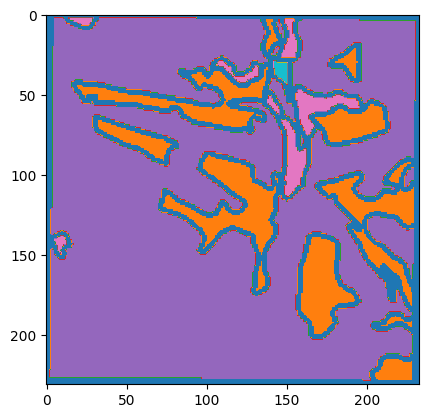

In [35]:
plt.imshow(rasterized, cmap="tab10")

In [39]:
composites.dtype

dtype('float64')

In [36]:
cdata = (composites.drop_sel({"band": "SCL"})
        .transpose("y", "x", "time", "band")
        .to_numpy())

/home/mjonir/mambaforge/envs/time-series-for-lulc/lib/python3.11/site-packages/dask/array/chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)


In [40]:
cdata

array([[[[  35. ,  122. ,   76.5, ..., 1257.5,  618. ,  282.5],
         [  52.5,  128.5,   80. , ..., 1292.5,  631.5,  298.5],
         [  38.5,  117. ,   73.5, ..., 1241. ,  639. ,  294.5],
         ...,
         [   0. ,    0. ,    0. , ...,    0. ,    0. ,    0. ],
         [  72. ,  154. ,  119.5, ..., 1156. ,  696.5,  353. ],
         [  86.5,  151.5,  132.5, ..., 1147.5,  727. ,  373.5]],

        [[  52. ,  129. ,   95. , ..., 1257.5,  618. ,  282.5],
         [  72.5,  158. ,   99.5, ..., 1292.5,  631.5,  298.5],
         [  55.5,  148. ,  101. , ..., 1241. ,  639. ,  294.5],
         ...,
         [   0. ,    0. ,    0. , ...,    0. ,    0. ,    0. ],
         [  85.5,  169.5,  146.5, ..., 1156. ,  696.5,  353. ],
         [  97. ,  184. ,  154.5, ..., 1147.5,  727. ,  373.5]],

        [[  67. ,  161. ,  112.5, ..., 1325.5,  738. ,  349. ],
         [  90.5,  170. ,  126. , ..., 1325. ,  758.5,  360. ],
         [  72. ,  165. ,  132. , ..., 1263. ,  756.5,  355. ],
        

In [41]:
cdata = cdata.reshape((-1, *cdata.shape[2:]))

In [42]:
cdata.shape

(53823, 9, 10)

In [43]:
ydata = rasterized.ravel()

In [44]:
ydata.shape

(53823,)

In [45]:
cdata = cdata[ydata != 0]
ydata = ydata[ydata != 0]

In [46]:
cdata.shape

(44460, 9, 10)

In [47]:
ydata.shape

(44460,)

In [52]:
np.savez(file=f"{geojson[8].stem}.npz", X=cdata, y=ydata)

In [51]:
geojson[8]

PosixPath('../data/geojson/3485-7268-14.geojson')

In [56]:
dd = np.load("3485-7268-14.npz")

In [60]:
dd["X"].shape, dd["y"].shape

((44460, 9, 10), (44460,))

In [20]:
composites

<xarray.Dataset>
Dimensions:                     (band: 11, time: 9, y: 231, x: 233)
Coordinates: (12/17)
  * band                        (band) <U8 'B02' 'B03' 'B04' ... 'B12' 'SCL'
    center_wavelength           (band) float64 dask.array<chunksize=(11,), meta=np.ndarray>
    common_name                 (band) object dask.array<chunksize=(11,), meta=np.ndarray>
    constellation               <U10 ...
    epsg                        int64 ...
    full_width_half_max         (band) float64 dask.array<chunksize=(11,), meta=np.ndarray>
    ...                          ...
    sentinel:valid_cloud_cover  bool ...
    title                       (band) <U31 dask.array<chunksize=(11,), meta=np.ndarray>
    view:off_nadir              int64 ...
  * x                           (x) float64 2.351e+06 2.351e+06 ... 2.354e+06
  * y                           (y) float64 8.774e+05 8.773e+05 ... 8.75e+05
  * time                        (time) datetime64[ns] 2021-12-03 ... 2022-03-25
Data variables:
    imagery                     (time, band, y, x) float64 dask.array<chunksize=(1, 3, 116, 117), meta=np.ndarray>
    training                    (time, y, x) uint8 dask.array<chunksize=(1, 231, 233), meta=np.ndarray>

In [21]:
rgb = composites.imagery.sel(band=["B04", "B03", "B02"])
# plt.imshow(rgb[0].values.transpose(1,2,0))

In [22]:
rgb

<xarray.DataArray 'imagery' (time: 9, band: 3, y: 231, x: 233)>
dask.array<getitem, shape=(9, 3, 231, 233), dtype=float64, chunksize=(1, 3, 116, 117), chunktype=numpy.ndarray>
Coordinates: (12/17)
  * band                        (band) <U8 'B04' 'B03' 'B02'
    center_wavelength           (band) float64 dask.array<chunksize=(3,), meta=np.ndarray>
    common_name                 (band) object dask.array<chunksize=(3,), meta=np.ndarray>
    constellation               <U10 ...
    epsg                        int64 ...
    full_width_half_max         (band) float64 dask.array<chunksize=(3,), meta=np.ndarray>
    ...                          ...
    sentinel:valid_cloud_cover  bool ...
    title                       (band) <U31 dask.array<chunksize=(3,), meta=np.ndarray>
    view:off_nadir              int64 ...
  * x                           (x) float64 2.351e+06 2.351e+06 ... 2.354e+06
  * y                           (y) float64 8.774e+05 8.773e+05 ... 8.75e+05
  * time                        (time) datetime64[ns] 2021-12-03 ... 2022-03-25
Attributes:
    crs:         epsg:6362
    resolution:  10
    transform:   [10.0, 0.0, 2351230.0, 0.0, -10.0, 877350.0, 0.0, 0.0, 1.0]

In [23]:
np.max(rgb[0].values), np.min(rgb[0].values), np.mean(rgb[0].values), np.median(rgb[0].values)

(2372.0, 1.5, 303.0930581102255, 252.0)

In [24]:
im = np.clip(255 * rgb[0]/3000, 0, 255).values.transpose(1,2,0).astype("uint8")

In [25]:

str(rgb[0].time.data.astype('datetime64[D]'))

'2021-12-03'

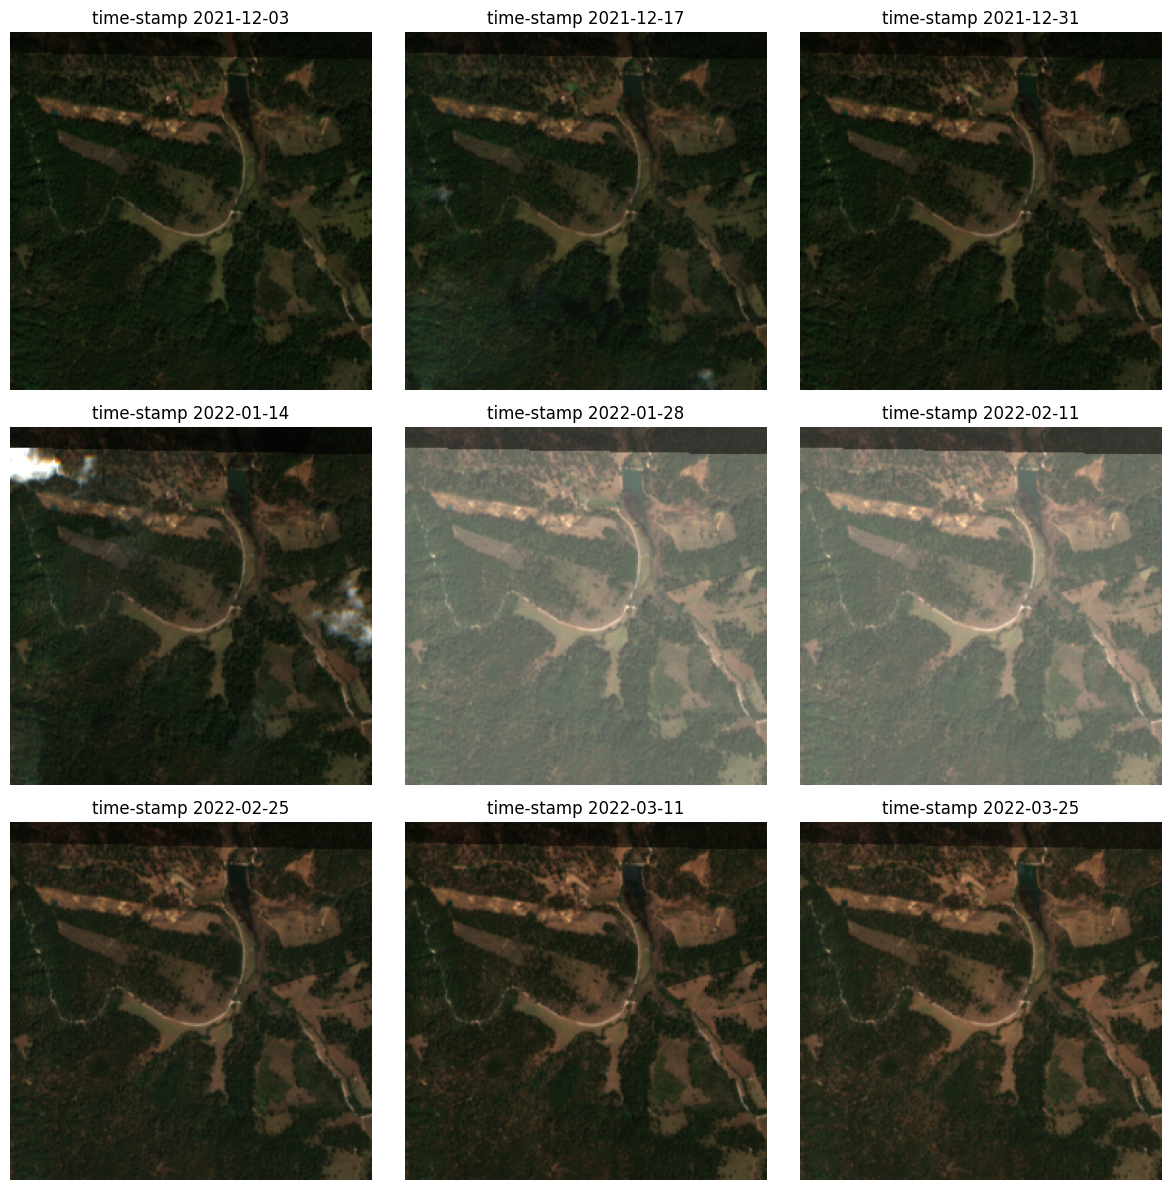

In [26]:
fig, axs = plt.subplots(3, 3, figsize=(12, 12))

# Flatten the axis array for easier indexing
axs = axs.ravel()

# Loop over each image and plot it in a separate axis
for i in range(9):
    im = np.clip(255 * rgb[i]/3000, 0, 255).values.transpose(1,2,0).astype("uint8")
    axs[i].imshow(im)
    axs[i].set_title(f"time-stamp {str(rgb[i].time.data.astype('datetime64[D]'))}")
    axs[i].axis("off")

# Show the figure
plt.tight_layout()
plt.show()

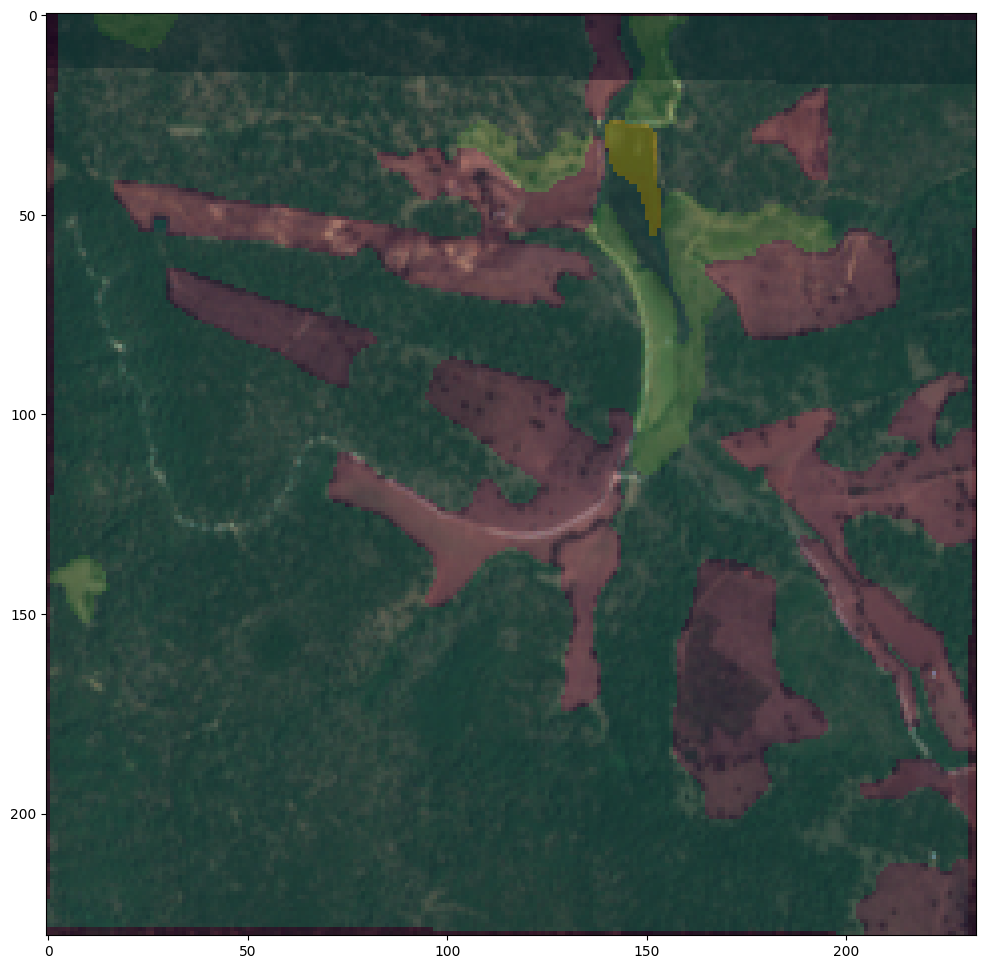

In [27]:
msk = composites.training[0]
fig,ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 12))

ax.imshow(im)
ax.imshow(msk, alpha=0.3)

In [30]:
import xbatcher
import xarray as xr
import numpy as np

In [48]:
da = xr.DataArray(data=np.random.rand(12, 5, 100, 100), 
                  dims=["t", "b", "h", "w"],
                  name="foo").chunk({"h": 1, "w": 1})

In [49]:
da

<xarray.DataArray 'foo' (t: 12, b: 5, h: 100, w: 100)>
dask.array<xarray-<this-array>, shape=(12, 5, 100, 100), dtype=float64, chunksize=(12, 5, 1, 1), chunktype=numpy.ndarray>
Dimensions without coordinates: t, b, h, w

In [62]:
batch = xbatcher.BatchGenerator(ds=da, 
                                input_dims={"h": 1, "w": 1},
                                input_overlap={},
                                # batch_dims={"t": 12, "b": 5},
                                concat_input_dims=False
                            )

In [63]:
next(iter(batch)).shape

(60, 1, 1)

In [42]:
for b in batch:
    print(b.shape)

(12, 1, 1)
(12, 1, 1)
(12, 1, 1)
(12, 1, 1)
(12, 1, 1)
(12, 1, 1)
(12, 1, 1)
(12, 1, 1)
(12, 1, 1)
(12, 1, 1)
(12, 1, 1)
(12, 1, 1)
(12, 1, 1)
(12, 1, 1)
(12, 1, 1)
(12, 1, 1)
(12, 1, 1)
(12, 1, 1)
(12, 1, 1)
(12, 1, 1)
(12, 1, 1)
(12, 1, 1)
(12, 1, 1)
(12, 1, 1)
(12, 1, 1)
(12, 1, 1)
(12, 1, 1)
(12, 1, 1)
(12, 1, 1)
(12, 1, 1)
(12, 1, 1)
(12, 1, 1)
(12, 1, 1)
(12, 1, 1)
(12, 1, 1)
(12, 1, 1)
(12, 1, 1)
(12, 1, 1)
(12, 1, 1)
(12, 1, 1)
(12, 1, 1)
(12, 1, 1)
(12, 1, 1)
(12, 1, 1)
(12, 1, 1)
(12, 1, 1)
(12, 1, 1)
(12, 1, 1)
(12, 1, 1)
(12, 1, 1)
(12, 1, 1)
(12, 1, 1)
(12, 1, 1)
(12, 1, 1)
(12, 1, 1)
(12, 1, 1)
(12, 1, 1)
(12, 1, 1)
(12, 1, 1)
(12, 1, 1)
(12, 1, 1)
(12, 1, 1)
(12, 1, 1)
(12, 1, 1)
(12, 1, 1)
(12, 1, 1)
(12, 1, 1)
(12, 1, 1)
(12, 1, 1)
(12, 1, 1)
(12, 1, 1)
(12, 1, 1)
(12, 1, 1)
(12, 1, 1)
(12, 1, 1)
(12, 1, 1)
(12, 1, 1)
(12, 1, 1)
(12, 1, 1)
(12, 1, 1)
(12, 1, 1)
(12, 1, 1)
(12, 1, 1)
(12, 1, 1)
(12, 1, 1)
(12, 1, 1)
(12, 1, 1)
(12, 1, 1)
(12, 1, 1)
(12, 1, 1)
(12, 1, 1)

In [40]:
b

<xarray.DataArray 'foo' (sample: 10000, t: 3)>
array([[0.83471585, 0.29664901, 0.09891751],
       [0.29685043, 0.20832209, 0.97056854],
       [0.8630213 , 0.43081743, 0.97801534],
       ...,
       [0.51804247, 0.25222385, 0.35862432],
       [0.09985914, 0.73081449, 0.27627971],
       [0.3453597 , 0.61706229, 0.60523007]])
Coordinates:
  * sample   (sample) object MultiIndex
  * h        (sample) int64 0 0 0 0 0 0 0 0 0 0 ... 99 99 99 99 99 99 99 99 99
  * w        (sample) int64 0 1 2 3 4 5 6 7 8 9 ... 91 92 93 94 95 96 97 98 99
Dimensions without coordinates: t